The project's first two steps from where this notebook is continuing, were documented on the previous notebooks:

*   `01_data_preparation.ipynb`
*   `02_model_development.ipynb`



# **Model Interpretation an Explainability**
After developing and validating our predictive model, it is crucial to understand **how and why** it makes decisions. This notebook focuses on **interpreting the model's behavior**, providing insights into the most influential features, both **globally** (on average) and **locally** (for individual predictions).

By applying **explainable AI techniques**, we aim to:
- Improve trust in model predictions
- Identify biases or unexpected patterns
- Support business decisions based on feature influence

##**Techniques to be applied**

## Importing libraries

In [7]:
from google.cloud import storage
import joblib
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import plot_importance

## Downloading and loading model from Google Cloud Storage

In [3]:
bucket_name = "portfolio-projects-files"
source_blob_name = "portfolio-projects-files/model_churn.pkl"
local_model_path = "/tmp/model_churn.pkl"

In [6]:
# Downloading model from Google Storage
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(source_blob_name)
blob.download_to_filename(local_model_path)
print("Succesfully downloaded")

# Loading modelo with joblib
model = joblib.load(local_model_path)
print("Model succesfully loaded:", type(model))

Succesfully downloaded
Model succesfully loaded: <class 'xgboost.sklearn.XGBClassifier'>


We will use a combination of **model-agnostic** and **model-specific** tools to explore feature importance:

###  Global Interpretability
- **Feature Importance (Built-in from XGBoost)**  
  → Understand which features the model relies on most overall.
  
- **SHAP Summary Plot (SHapley Additive exPlanations)**  
  → A unified view of feature impact and direction across the dataset.

- **Partial Dependence Plots (PDP)**  
  → Visualize the marginal effect of individual features on the prediction.

###  Local Interpretability
- **SHAP Force Plot**  
  → Explain specific predictions in terms of feature contributions.

- **LIME (Local Interpretable Model-agnostic Explanations)**  
  → Break down individual predictions into understandable components.

## **Global Features Analysis**
The Feature Importance plots shows which variables the model relied on most to make predictions.
It reflects how frequently and effectively each feature was used in the decision trees.
This helps identify the most relevant drivers of churn overall.

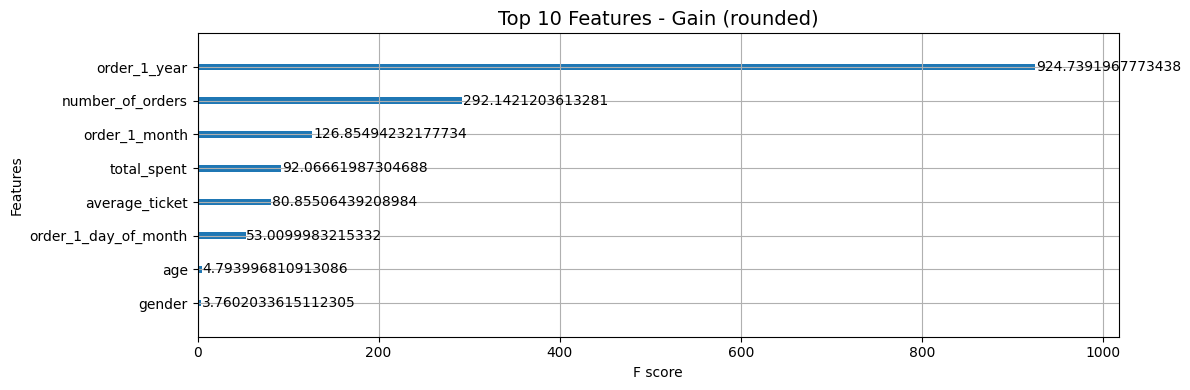

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_importance(model,
                max_num_features=10,
                importance_type='gain',
                ax=ax)
plt.title("Top 10 Features - Gain (rounded)", fontsize=14)
plt.tight_layout()
plt.show()

**Interpretation:** This chart shows the average information gain each feature provides for the model's decision-making process. The higher the gain, the more relevant the feature is for XGBoost when making predictions.


### **SHAP Summary Charts**
The SHAP Summary plots combines feature importance with the direction of impact.
It shows how much each feature contributes (positively or negatively) to the prediction for each instance.
It is one of the most robust and interpretable global explanations available for complex models.

In [43]:
df = pd.read_csv("/content/clients_info.csv")

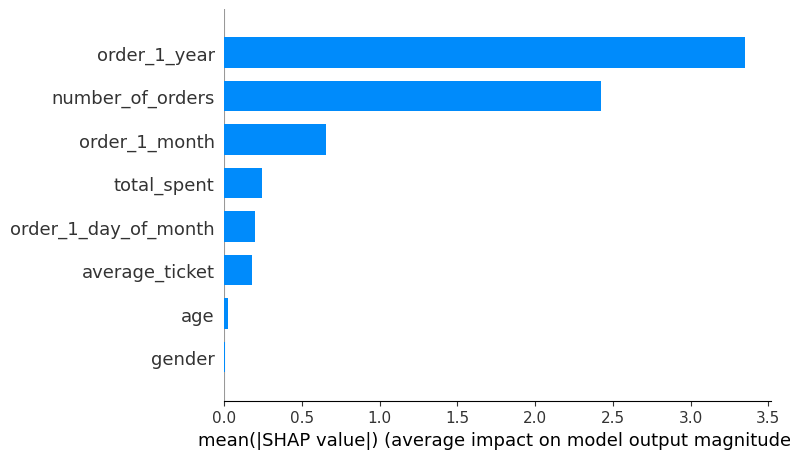

In [55]:
import shap
import pandas as pd
from sklearn.model_selection import train_test_split

X = df.drop([
    'churn',
    'recency',
    't_12', 't_23', 't_34',
    'order_2_year', 'order_2_month', 'order_2_day_of_month',
    'order_3_year', 'order_3_month', 'order_3_day_of_month',
    'order_4_year', 'order_4_month', 'order_4_day_of_month'
], axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=99)

# Criando o explainer SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Plot SHAP Summary
shap.summary_plot(shap_values, X, plot_type="bar")


**Interpretation:** The bar chart shows the average absolute impact of each feature on the prediction.  
It is useful to understand which variables most influence the model, without considering the direction (positive or negative).


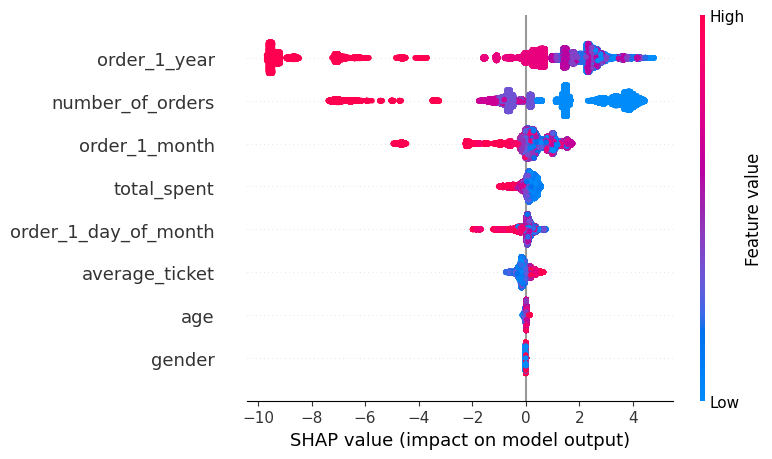

In [45]:
# SHAP Summary (Dot plot)
shap.summary_plot(shap_values, X)


**Explanation:** The scatter plot shows not only the average impact but also the direction of influence for each feature:

- **Red**: high feature values  
- **Blue**: low feature values  
- **To the right**: increases the likelihood of churn  
- **To the left**: decreases the likelihood of churn


### **Partial Dependence Plots (PDP)**
The PDP (Partial Dependence Plot) shows how each variable influences the predicted probability of churn while keeping the other variables constant.

These plots are particularly useful for providing global explanations of the model.

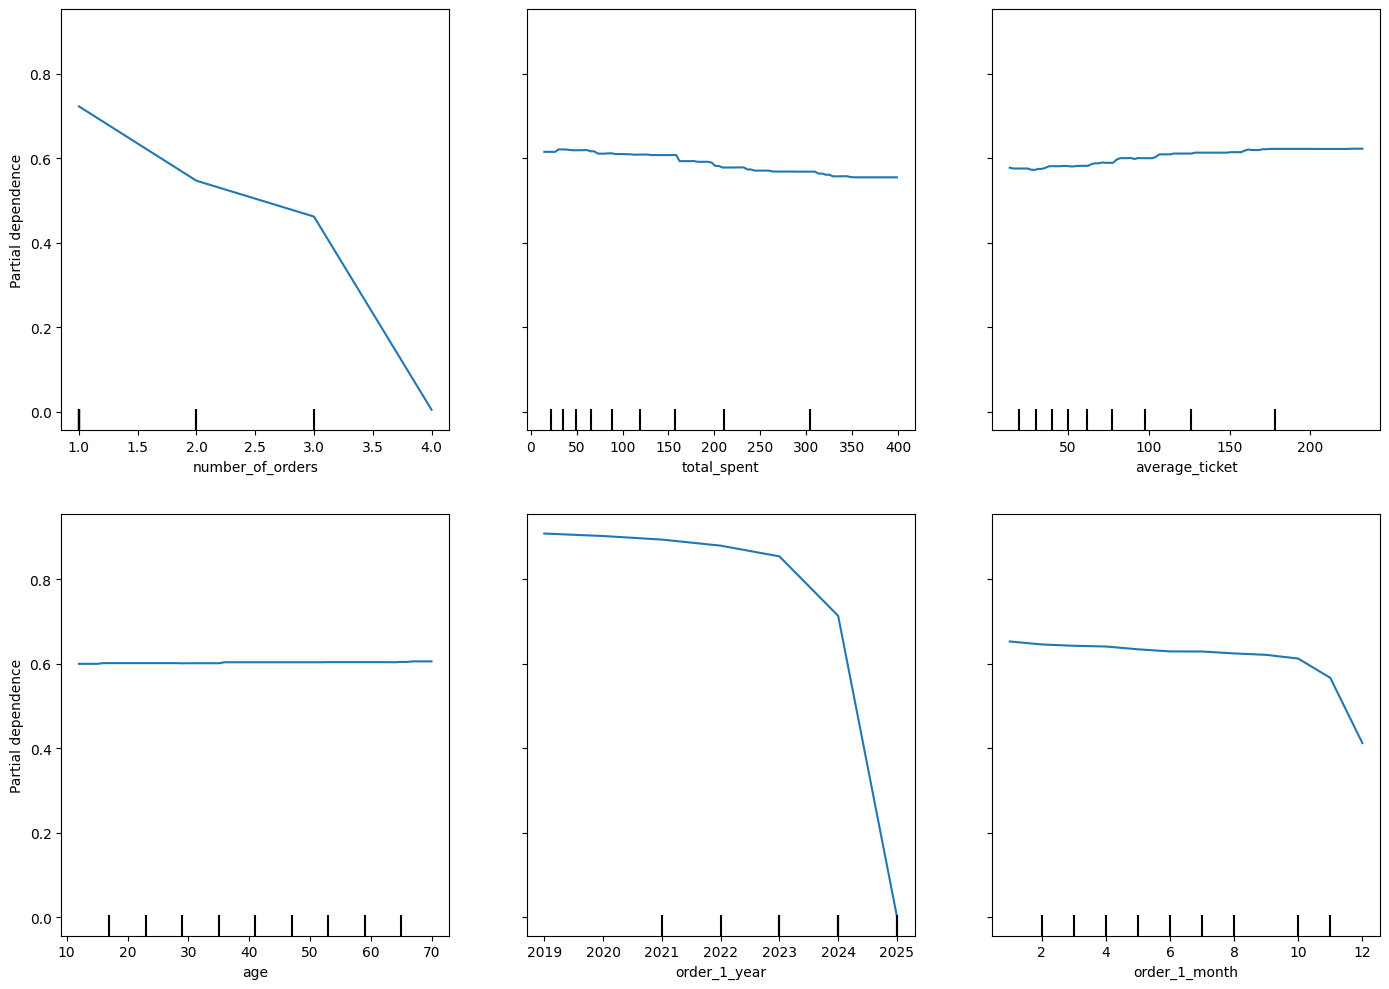

In [60]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Lista com as principais variáveis para plotar os PDPs
features_to_plot = ['number_of_orders', 'total_spent', 'average_ticket', 'age', 'order_1_year', 'order_1_month']

# Geração dos gráficos
fig, ax = plt.subplots(figsize=(14, 10))  # Ajuste o tamanho conforme necessário

PartialDependenceDisplay.from_estimator(
    model,           # Seu modelo treinado (XGBClassifier)
    X_train,         # Dados de entrada (sem o target)
    features_to_plot,
    kind='average',  # Média marginal (padrão)
    ax=ax
)

plt.tight_layout()
plt.show()


### **ICE plots (Individual Conditional Expectation)**
ICE plots (Individual Conditional Expectation) complement PDPs by showing how each individual instance (e.g., each customer) responds to variations in a specific feature.


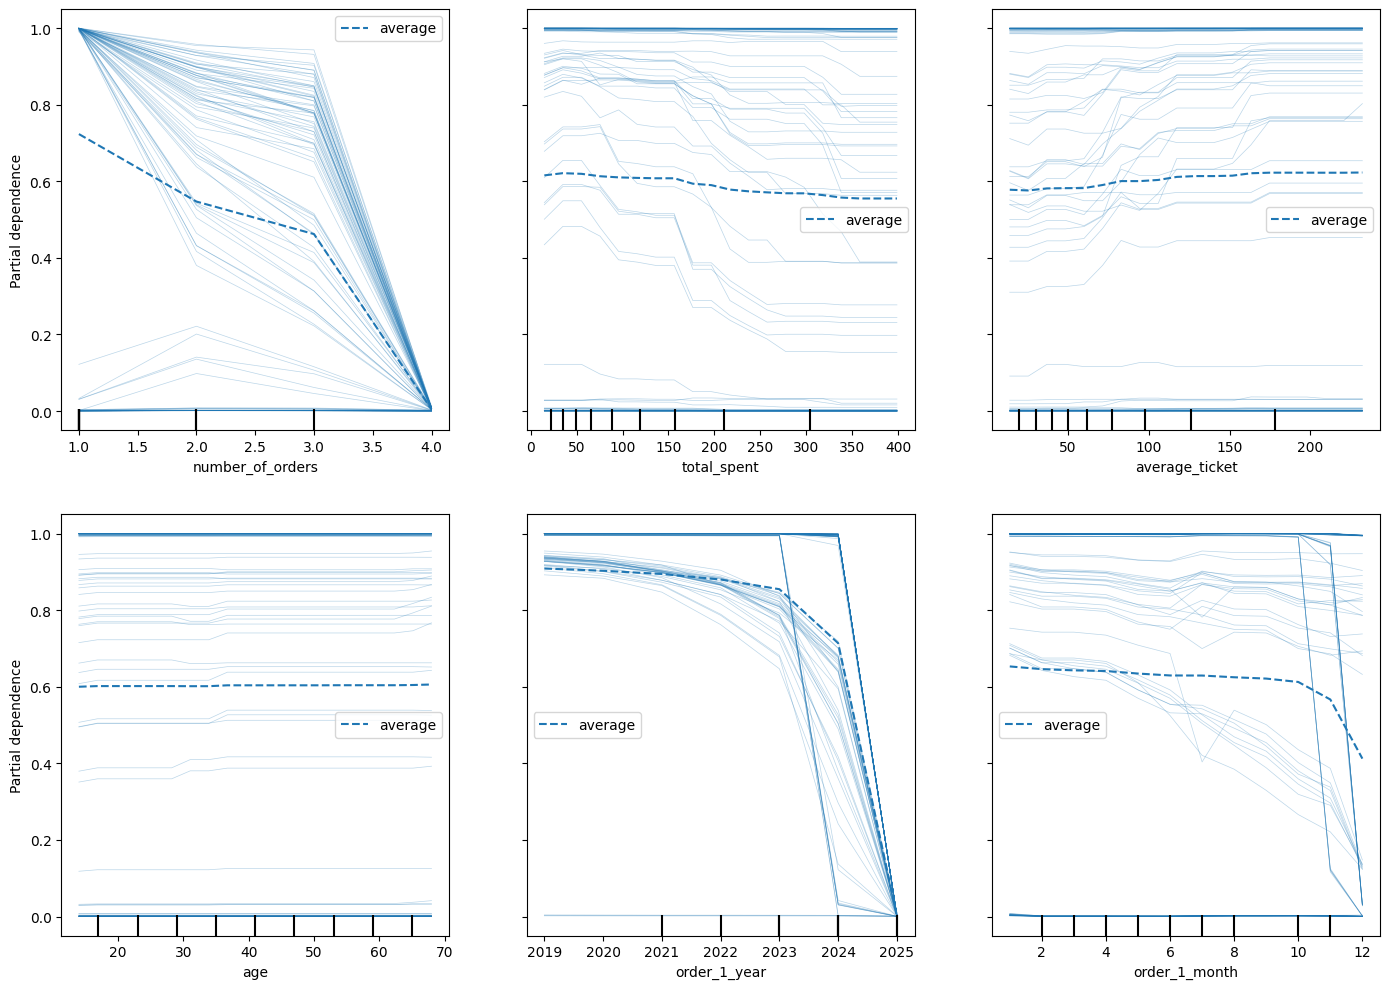

In [59]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Features que você quer visualizar
features_to_plot = ['number_of_orders', 'total_spent', 'average_ticket', 'age', 'order_1_year', 'order_1_month']

# Geração dos gráficos com ICE ativado
fig, ax = plt.subplots(figsize=(14, 10))  # Tamanho maior para melhor visualização

PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    features_to_plot,
    kind='both',           # 'average' (PDP), 'individual' (ICE) ou 'both'
    subsample=100,         # Limita nº de linhas individuais no ICE para legibilidade
    grid_resolution=20,    # Nº de pontos para a feature no gráfico
    random_state=42,
    ax=ax
)

plt.tight_layout()
plt.show()


## **Local Interpretability - Individual analysis**
These charts provide local interpretation, in other words, they are tools when we want to analyse one customer or a range of costumers, specifically. Here two powerful ones.

### **SHAP Force Plot**
The SHAP Force Plot offers a detailed local explanation by visualizing how each feature contributed to a specific prediction. It shows which variables pushed the prediction higher or lower, giving insight into **why** the model decided for churn or not.  



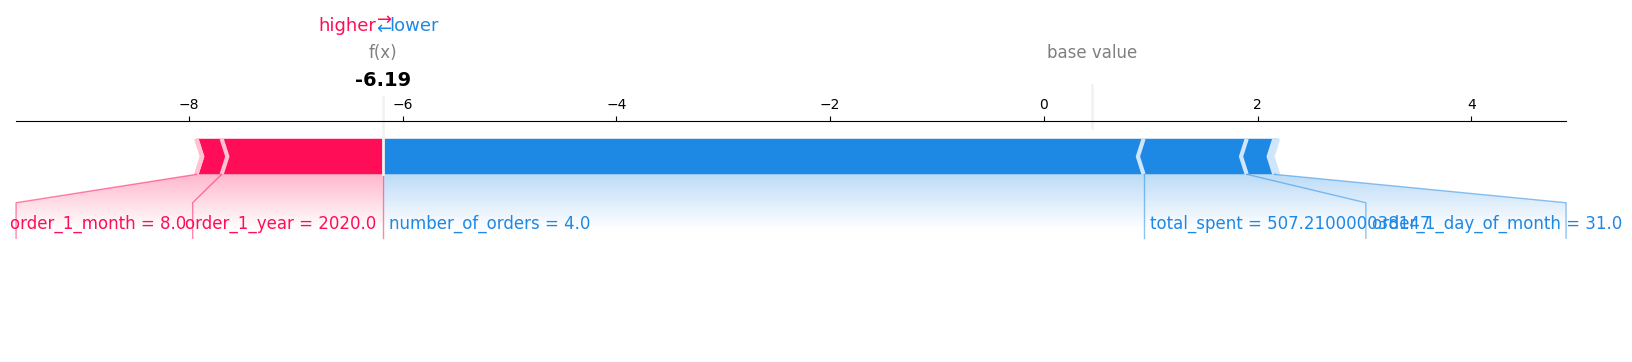

In [56]:
import shap

# Garante que usamos o mesmo explainer já treinado
explainer = shap.Explainer(model)

# Escolhe um exemplo individual (ex: o primeiro da base de teste)
i = 0
shap_values = explainer(X_test)

# Exibe o Force Plot para o exemplo i
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i].values, X_test.iloc[i], matplotlib=True)


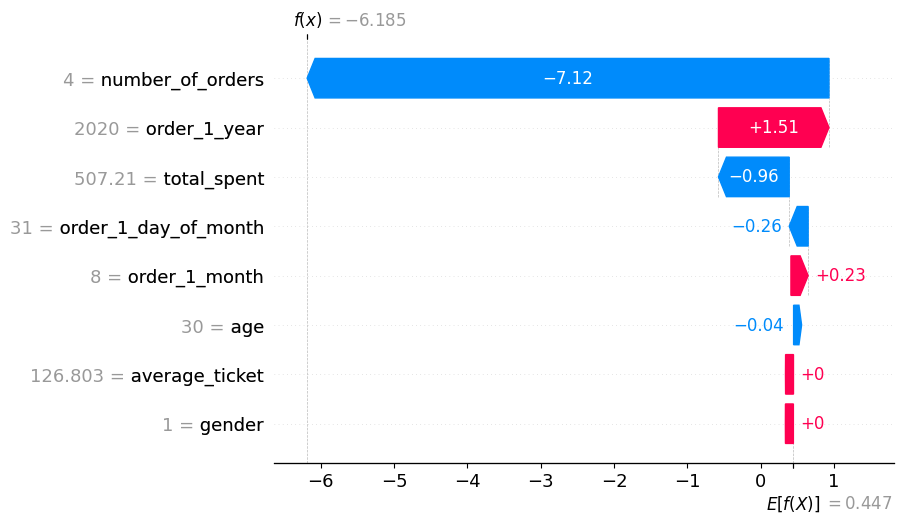

In [63]:
shap.plots.waterfall(shap_values[0])

### **🧠 LIME (Local Interpretable Model-agnostic Explanations)**
LIME creates a simple surrogate model (like a linear model) to approximate how the original model behaves around a specific data point. It explains **locally** which features had the most influence on the prediction. Helps validate and understand individual decisions in a model-agnostic way.


In [57]:
!pip install lime --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [58]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Not Churn', 'Churn'],
    mode='classification'
)

i = 0
exp = explainer.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=model.predict_proba
)

exp.show_in_notebook(show_table=True)


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

## **Summary: Interpreting the Model's Limitations and Value**

The model achieved excellent performance in terms of accuracy, F1-score, and recall, even after applying robust validation techniques such as cross-validation, nested cross-validation, and Bayesian optimization.

However, during the model interpretation phase, it became clear that the most influential features in predicting churn were:

- **Number of orders**
- **Year and month of first purchase**
- **Total Spent ($)***

These results are logically consistent with the churn definition created earlier in the project, which was based on customer purchase stages and recency relative to median time between purchases.

While this consistency confirms the model is technically sound and has learned the rules provided, it also raises an important observation:

> **The model is great at replicating the defined rule.**
> **It needs improves on feature engineering, however, to generate new insights**

### Next Steps for Increasing Business Value

- **Include new behavioral or transactional features** (e.g., product categories, acquisition channel, engagement metrics).
- **Redefine churn** based on longer-term inactivity or external benchmarks rather than solely on number of orders.
- Explore more nuanced modeling approaches, such as:
  - Survival analysis models
  - Time-to-event regression
  - Interpretable models with richer feature sets
